In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

In [3]:
input_1 = os.path.join("Population_Data","New_York_City_Population_By_Community_Districts.csv")
population_data = pd.read_csv(input_1)

In [4]:
population_data = population_data.rename(columns={'1970 Population': 1970,
 '1980 Population': 1980,
 '1990 Population': 1990,
 '2000 Population': 2000,
 '2010 Population': 2010})

year_list = [1970,1980,1990,2000,2010]

In [5]:
community_districts = population_data.copy()[["Borough","CD Number",1990,2000,2010]]
community_districts["CD_ID"] = community_districts["Borough"] + " " + community_districts["CD Number"].map(str)
community_districts=community_districts.set_index("CD_ID")

In [6]:
borough_gb=population_data.groupby("Borough")

<h2> Scaled Intercensal Population Estimates for Boroughs </h2>
<p> A <a href="https://www2.census.gov/programs-surveys/popest/technical-documentation/methodology/2010-2019/2019-natstcopr-meth.pdf"> common practice </a> in producing intercensal data estimates is "controlling" an estimate to a given population total.  Each borough of New York City is its own county.  A naive approach to controlling to the total population of each borough would be to use the intercensal population estimate from the US Census of the county corresponding to each borough to scale our population estimates. </p>

<p> There is a problem with this approach, however; a brief survey of various datasets using New York City Census Data showed that no two datasets agree on the precise population totals in each borough or in the city as a whole (see <a href="https://data.cityofnewyork.us/City-Government/New-York-City-Population-by-Borough-1950-2040/xywu-7bv9/data"> NYC Open Data: Boroughs </a> ,  <a href="https://www.census.gov/data/tables/time-series/demo/popest/2010s-counties-total.html#par_textimage_242301767">
Census Data by County </a>).  Therefore, we use the total population of each borough, as computed by our primary dataset, to scale the intercensal estimates.   </p>

<p> The above approach still is not complete. Because we have decenial data in our primary data set set, we could compute a scale factor from the populations of each borough in 1990, 2000, or 2010.  For the years 1990, 2000, and 2010, use the totals provided by our primary dataset for that year.  For continuity, we estimate borough level population in intermediate years as a linear combination of decenial estimates, weighted by proximity to the decenial. </p>

<p> The files containing borough level population data are included in this repository.  However, because one of the borough-level datasets was available only in PDF form, we have hard-coded the population values below. </p>






In [7]:
Boroughs = {"Bronx":[1207053,1214835,1223153,1238907,
                    1250789,1262064,1272693,1285683,
                    1300823,1317895],
            "Brooklyn":[2303679,2312518,2327759,2347687,
                        2361668,2372611,2383703,2401148,
                        2422434,2447352],
            "Manhattan":[1487073,1483644,1485877,1493582,
                         1503909,1514184,1521415,1527384,
                         1531067,1535624],
            "Queens":[1957281,1975556,1996512,2023400,
                      2047884,2074581,2105520,2138503,
                      2174983,2208975],
            "Staten Island":[380564,387948,395643,402590,
                             406208,409600,414481,420725,
                             428952,437814]}

Borough_County = {"Bronx":"Bronx",
"Brooklyn":"Kings",
"Manhattan":"New York",
"Queens":"Queens",
"Staten Island":"Richmond"}


In [8]:
def county_name(my_str):
    answer = my_str.split(" County")[0]
    if answer[0]==".":
        return answer.split(".",1)[1]
    else:
        return answer
    
def comma_del(my_str):
    if type(my_str) is str:
        dig_list = my_str.split(",")
        output = ""
        for x in dig_list:
            output+=x
        return int(output)
    else:
        return my_str

In [9]:
input_2 = os.path.join("Population_Data","2000_2009_County.csv")
input_3 = os.path.join("Population_Data","2010_2018_County.csv")
df_2000=pd.read_csv(input_2,header=1).drop(0)
df_2010=pd.read_csv(input_3)
df_2000["County"]=df_2000["County"].map(county_name)
df_2000 = df_2000.set_index("County")
df_2010["County"]=df_2010["Geography"].map(county_name)
df_2010 = df_2010.set_index("County")

In [10]:
for borough in Boroughs:
    county = Borough_County[borough]
    for year in range(2000,2010):
        Boroughs[borough].append(comma_del(df_2000[str(year)][county]))
    for year in range(2010,2019):
        Boroughs[borough].append(comma_del(df_2010[str(year)][county]))

In [11]:
Boroughs_df = pd.DataFrame(Boroughs).transpose()
for i in range(0,30):
    Boroughs_df = Boroughs_df.rename(columns = {i:1990+i})

In [12]:
scale_factors = {}
for borough in Boroughs:
    scale_factors[borough] = []
    for year in [1990,2000,2010]:
        actual = borough_gb.sum()[year][borough]
        estimate = Boroughs_df[year][borough]
        ratio = actual / estimate
        scale_factors[borough].append(ratio)
        
scale_by = pd.DataFrame(scale_factors).transpose().rename(columns={0:1990,1:2000,2:2010})

In [13]:
estimate={1990:None,2000:None,2010:None}
for year in estimate:
    df = Boroughs_df.transpose()
    for borough in Boroughs:
        df[borough] = round(df[borough]*scale_by[year][borough],0)
    estimate[year]=df.transpose()
    

In [14]:
borough_annual_estimate = Boroughs_df.copy()
for year in range(1990,2019):
    for borough in Boroughs:
        if 1990<=year & year<2000:
            borough_annual_estimate[year][borough] = estimate[1990][year][borough]*((2000-year)/10) + \
                                                    estimate[2000][year][borough]*((year-1990)/10)
        elif 2000<=year & year<2010:
            borough_annual_estimate[year][borough] = estimate[2000][year][borough]*((2010-year)/10) + \
                                                    estimate[2010][year][borough]*((year-2000)/10)
        elif 2010<=year:
            borough_annual_estimate[year][borough] = estimate[2010][year][borough]
            

In [15]:
borough_annual_estimate

,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
Bronx,1197420,1205484,1214085,1230073,1242225,1253781,1264701,1277974,1293392,1310741,...,1369610,1380697,1390662,1404942,1415516,1424670,1433814,1438303,1432818,1425261
Brooklyn,2300650,2309621,2324988,2345038,2359151,2370230,2381460,2399038,2420456,2445506,...,2482879,2504609,2535489,2563484,2583068,2597217,2605128,2605751,2590935,2577409
Manhattan,1479844,1476075,1477940,1485244,1495152,1505004,1511826,1517390,1520681,1524838,...,1572078,1577385,1596702,1612412,1616152,1619270,1624996,1624547,1618112,1617041
Queens,1965471,1983881,2004987,2032050,2056701,2083576,2114712,2147904,2184611,2218820,...,2223765,2241021,2261893,2279128,2294620,2306608,2314095,2315517,2303315,2285306
Staten Island,378706,386012,393627,400495,404052,407382,412193,418358,426493,435257,...,465207,467968,469343,469000,470237,470413,470858,472545,473842,474503


<h2> Borough Population-Controlled Estimates for Community District Population </h2>

Official intercensal population estimates make use of granular data about variables like average household occupancy, group residential (i.e. hospitals, universities, jails) occupancy, and more.  However, the use of such data is outside the scope of this project.  Instead, we produce population estimates for each community district in two stages:

First, we use a linear function to estimate the populations between consecutive decenial measurements.  Then, we normalize (control) our estimates so that the sum of the estimated populations of the community districts within each borough matches the borough population estimate computed above.

<h4> Linear Interpolation of Decenial Measurements </h4>

In [16]:
# We use a weighted average of the two closest decenial measurements to compute annual estimates of community
# district population.  Using a weighted average is equivalent to assuming linear growth in intercensal years.
linear_estimates = community_districts.copy()
for year in range(1990,2019):
    if 1990<=year & year<2000:
        linear_estimates[f"{year} estimate"] = linear_estimates[1990]*((2000-year)/10) + \
                                                    linear_estimates[2000]*((year-1990)/10)

    elif 2000<=year:
        linear_estimates[f"{year} estimate"] = linear_estimates[2000]*((2010-year)/10) + \
                                                    linear_estimates[2010]*((year-2000)/10)

            
linear_estimates = linear_estimates.drop([1990,2000,2010],axis=1)
column_names = {f"{year} estimate":year for year in range(1990,2019)}
linear_estimates = linear_estimates.rename(columns = column_names)

<h4> Controlling Community District Estimates to Borough Population Estimates </h4>

In [17]:
borough_estimate_gb = linear_estimates.groupby("Borough")

In [18]:
cd_scale_factors = borough_annual_estimate / borough_estimate_gb.sum().drop("CD Number",axis=1)

In [19]:
final_estimates = linear_estimates.copy()
cd_reference = final_estimates.index.tolist()
for year in range(1990,2019):
    for cd in cd_reference:
        borough = final_estimates.loc[cd,"Borough"]
        final_estimates.loc[cd,year] = linear_estimates.loc[cd,year] * \
                                            cd_scale_factors.loc[borough,year]

    

In [20]:
final_estimates.head()

,Borough,CD Number,1990,1991,1992,1993,1994,1995,1996,1997,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
CD_ID,,,,,,,,,,,,,,,,,,,,,
Bronx 1,Bronx,1,77214.0,77391.393304,77605.860240,78292.870813,78735.102210,79140.123156,79505.863920,80019.936793,...,90183.747541,91497.0,92740.278371,94276.970332,95570.824555,96772.481922,97976.511446,98863.586492,99060.342574,99104.354520
Bronx 2,Bronx,2,39443.0,40017.132148,40606.750589,41443.115821,42150.799982,42837.751716,43502.194530,44247.204843,...,51487.165274,52246.0,52964.946346,53851.551215,54599.535124,55294.902872,55991.672104,56507.325035,56628.342551,56661.902348
Bronx 3,Bronx,3,57162.0,58065.280916,58990.496509,60274.094525,61370.667581,62436.940543,63470.232909,64620.992619,...,78313.691374,79762.0,81151.606465,82800.910157,84239.966147,85599.649217,86962.992232,88045.586800,88511.000548,88835.163296
Bronx 4,Bronx,4,119962.0,121424.569945,122936.264586,125195.272234,127065.044785,128872.773067,130613.475896,132596.404166,...,145142.505920,146441.0,147621.419141,149261.081961,150508.258444,151605.228876,152701.781665,153302.815435,152839.756494,152153.664546
Bronx 5,Bronx,5,118435.0,118935.468891,119491.172910,120774.220885,121680.093520,122528.076327,123314.654939,124331.018326,...,127674.105057,128200.0,128617.903577,129429.965287,129895.521632,130227.570782,130556.049898,130459.680010,129462.758125,128286.882507


In [21]:
final_estimates.to_csv("CD_Population_Estimates.csv")

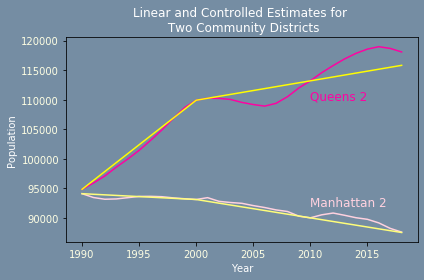

In [22]:
cd_1 = "Manhattan 2"
cd_2 = "Queens 2"
y_1 = final_estimates.loc[cd_1,:].drop(["CD Number","Borough"])
y_2 = linear_estimates.loc[cd_1,:].drop(["CD Number","Borough"])
y_3 = final_estimates.loc[cd_2,:].drop(["CD Number","Borough"])
y_4 = linear_estimates.loc[cd_2,:].drop(["CD Number","Borough"])
x = range(1990,2019)
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_facecolor("xkcd:blue/grey")
ax.tick_params(labelcolor="xkcd:off white")
fig.patch.set_facecolor("xkcd:blue/grey")
plt.plot(x,y_1,color="xkcd:light pink")
plt.plot(x,y_2,color="xkcd:light yellow")
plt.plot(x,y_3,color="xkcd:shocking pink")
plt.plot(x,y_4,color="xkcd:bright yellow")
plt.text(2010, 92000,f"{cd_1}",color="xkcd:light pink",size=12)
plt.text(2010,110000,f"{cd_2}",color="xkcd:shocking pink",size=12)
plt.xlabel("Year",color="xkcd:white")
plt.ylabel("Population",color="xkcd:white")
plt.title("Linear and Controlled Estimates for \n Two Community Districts",color="xkcd:white")
output_path_fig = os.path.join("..","Analysis_Images","Population_Estimate_Example")
plt.tight_layout()
plt.savefig(output_path_fig,facecolor=fig.get_facecolor())
plt.show()

In [23]:
final_estimates.to_html("pop data")